<a href="https://colab.research.google.com/github/hypro2/hands-on-LLM-from-colab/blob/main/mmBERT_DPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers>=5.0.0

In [ ]:
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
)
from sentence_transformers.evaluation import TripletEvaluator
from sentence_transformers.losses import CachedMultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

In [ ]:
lr = 8e-5
model_name = "jhu-clsp/mmBERT-small"
model_shortname = model_name.split("/")[-1]
model = SentenceTransformer(model_name)

In [ ]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# 2. 파인튜닝에 사용할 데이터셋 로드
try:
    full_dataset = load_dataset("json", data_files="hard_train_wipsglobal_search_dataset.json", split="train")
except FileNotFoundError:
    print("데이터 파일 'hard_train_wipsglobal_search_dataset.json'을 찾을 수 없습니다.")
    exit()


# 3. 데이터셋을 학습(80%), 검증(10%), 테스트(10%)용으로 분할

# 먼저 학습용(80%)과 나머지(20%)로 분할
train_test_split = full_dataset.train_test_split(test_size=0.2, seed=42) # 재현성을 위해 seed 추가
train_dataset = train_test_split["train"]
eval_test_dataset = train_test_split["test"] # 검증+테스트 데이터

# 나머지(20%)를 다시 반으로 나누어 검증용(10%)과 테스트용(10%)으로 분할
eval_test_split = eval_test_dataset.train_test_split(test_size=0.5, seed=42)
eval_dataset = eval_test_split["train"]
test_dataset = eval_test_split["test"]


print(f"전체 데이터셋 크기: {len(full_dataset)}")
print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(eval_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")

전체 데이터셋 크기: 15461
학습 데이터셋 크기: 12368
검증 데이터셋 크기: 1546
테스트 데이터셋 크기: 1547


In [ ]:
loss = CachedMultipleNegativesRankingLoss(model, mini_batch_size=16)
run_name = f"{model_shortname}-DPR-{lr}"

args = SentenceTransformerTrainingArguments(
    output_dir=f"output/{model_shortname}/{run_name}",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.05,
    fp16=True,  # Set to False if GPU can't handle FP16
    bf16=False,  # Set to True if GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    learning_rate=lr,
    save_strategy="steps",
    eval_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    save_total_limit=2,
    run_name=run_name,
)


In [ ]:
dev_evaluator = TripletEvaluator(
    anchors=eval_dataset["query"],
    positives=eval_dataset["document"],
    negatives=eval_dataset["negative"],
    name="hard_train_wipsglobal_search_dataset",
    show_progress_bar=True,
)
dev_evaluator(model)

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

{'hard_train_wipsglobal_search_dataset_cosine_accuracy': 0.77425616979599}

In [ ]:
# 6. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)
trainer.train()



Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: Currently logged in as: hyeong9647 (hyeong9647-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W0926 04:29:14.697000 3043 torch/_inductor/utils.py:1436] [1/1] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss
100,0.543700
200,0.024600
300,0.011000


TrainOutput(global_step=387, training_loss=0.15121747772823008, metrics={'train_runtime': 1473.2137, 'train_samples_per_second': 8.395, 'train_steps_per_second': 0.263, 'total_flos': 0.0, 'train_loss': 0.15121747772823008, 'epoch': 1.0})

In [ ]:
dev_evaluator = TripletEvaluator(
    anchors=test_dataset["query"],
    positives=test_dataset["document"],
    negatives=test_dataset["negative"],
    name="hard_train_wipsglobal_search_dataset",
    show_progress_bar=True,
)
dev_evaluator(model)

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

{'hard_train_wipsglobal_search_dataset_cosine_accuracy': 0.9993531703948975}

In [ ]:
model.save_pretrained(f"output/{model_shortname}/{run_name}/final")
# model.push_to_hub(run_name, private=False)

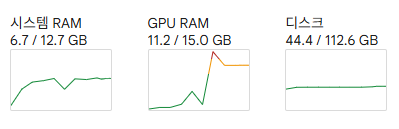

In [ ]:
!pip install -q -U transformers datasets evaluate peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 25.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
import re
import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")

!pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo evaluate
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
!pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.1.1
    Uninstalling datasets-4.1.1:
      Successfully uninstalled datasets-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.9.12 requires msgspec, which is not installed.
unsloth-zoo 2025.9.12 requires tyro, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 k

In [ ]:
from unsloth import FastModel
from transformers import AutoModelForSequenceClassification
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = False

model, tokenizer = FastModel.from_pretrained(
   model_name = "answerdotai/ModernBERT-base",
    auto_model = AutoModelForSequenceClassification,
    max_seq_length = max_seq_length,
    dtype = dtype,
    num_labels = 5,
    # full_finetuning = True,
    load_in_4bit = load_in_4bit,
)
model

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.9: Fast Modernbert patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [ ]:
model = FastModel.get_peft_model(
    model,
    r = 128,
    lora_alpha = 256,
    target_modules=["Wqkv", "Wo","Wi","dense"],
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,
    loftq_config = None,
    task_type="SEQ_CLS",
)

Unsloth: Making `model.base_model.model.model` require gradients
Unsloth: Upcasting `base_model.model.classifier` from float16 to float32 since it's in `modules_to_save`. Also allowing gradients.


In [ ]:
# import torch
# from datasets import load_dataset
# from torch.utils.data import DataLoader
# from transformers import DataCollatorWithPadding
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from peft import LoraConfig, get_peft_model

# model_name = 'jhu-clsp/mmBERT-small'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model =  AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, device_map='auto',torch_dtype="auto")
# model

In [ ]:
# # 다른 층은 훈련 제외하고 마지막 분류층만 훈련
# for parameter in model.parameters():
#     parameter.requires_grad = False
# for parameter in model.classifier.parameters():
#     parameter.requires_grad = True

# # LoRA 설정
# lora_config = LoraConfig(
#     r=64,  # Low-rank의 차원
#     lora_alpha=128,  # LoRA alpha
#     lora_dropout=0.1,  # Dropout 비율
#     task_type="SEQ_CLS",  # 시퀀스 분류
#     target_modules=["Wqkv", "Wo","Wi","dense"],
# )

# # LoRA 모델 설정
# model = get_peft_model(model, lora_config)

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# 1. CSV 파일 읽기
train_df = pd.read_csv("/content/drive/MyDrive/05_sentence.csv")
eval_df = pd.read_csv("/content/drive/MyDrive/05_sentence_eval.csv")


train_df["document"] = train_df[["ti", "ab","clr"]].fillna("").agg(" ".join, axis=1)
eval_df["document"] = eval_df[["ti", "ab","clr"]].fillna("").agg(" ".join, axis=1)

train_df = train_df[["skey", "document", "label_idx"]].rename(columns={"label_idx": "label"})
eval_df = eval_df[["skey", "document", "label_idx"]].rename(columns={"label_idx": "label"})


train_df['label'] = train_df['label'].astype('int')
eval_df['label'] = eval_df['label'].astype('int')


def preprocess_data(example, tokenizer):
    return tokenizer(example["document"], truncation=True)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(eval_df)
})

processed_dataset = dataset.map(
    lambda example: preprocess_data(example, tokenizer),
    batched=True,
    remove_columns=["skey", "document"]
).rename_column("label", "labels")

print(dataset)
print(processed_dataset)
print(processed_dataset["train"][0])
print(processed_dataset["test"][0])


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['skey', 'document', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['skey', 'document', 'label'],
        num_rows: 200
    })
})
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})
{'labels': 0, 'input_ids': [50281, 4238, 442, 281, 2341, 9436, 1293, 820, 19, 14839, 253, 3688, 3400, 247, 1332, 323, 2341, 11998, 432, 21209, 285, 6804, 8138, 17795, 253, 1332, 27532, 247, 289, 250, 383, 486, 44993, 314, 5114, 281, 4711, 247, 9946, 5969, 44993, 314, 5114, 3678, 534, 11903, 4219, 2341, 11998, 1293, 20437, 6315, 21295, 715, 253, 10825, 337, 247, 1232, 323, 13546, 2341, 432, 8138, 534, 12093, 247, 24396, 253, 8138, 270, 39861, 44993, 314, 5114, 273, 253, 8138, 387, 7469, 260, 281, 12891, 260, 281, 4711, 726, 1251, 284, 1018, 28

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

longest_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest",
    # padding="max_length",  # 'longest' 대신 'max_length' 사용
    # max_length=512         # 고정할 최대 길이 지정
)
longest_dataloader = DataLoader(
    processed_dataset["train"],
    collate_fn=longest_collator,
    batch_size=4,
    shuffle=False
)
longest_iterator = iter(longest_dataloader)
longest_batch = next(longest_iterator)
print("longest 패딩 입력 id shape :", longest_batch["input_ids"].shape)

longest 패딩 입력 id shape : torch.Size([4, 375])


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

In [ ]:
# from transformers import TrainingArguments,Trainer
# from unsloth import is_bfloat16_supported

# trainer = Trainer(
#     model = model,
#     processing_class = tokenizer,
#     eval_dataset = processed_dataset["test"],
#     train_dataset = processed_dataset["train"],
#     args = TrainingArguments(
#         per_device_train_batch_size = 32,
#         gradient_accumulation_steps = 1,
#         warmup_steps = 5,
#         num_train_epochs = 1, # bert-style models usually need more than 1 epoch
#         # max_steps = 60,
#         learning_rate = 5e-5,
#         fp16 = not is_bfloat16_supported(),
#         bf16 = is_bfloat16_supported(),
#         logging_steps = 1,
#         optim = "adamw_8bit",
#         weight_decay = 0.01,
#         eval_strategy="steps",
#         eval_steps=0.10,  # Evaluate every 10% of total training steps
#         lr_scheduler_type = "linear",
#         seed = 3407,
#         output_dir = "outputs",
#         report_to = "none", # Use this for WandB etc
#     ),
#     compute_metrics = compute_metrics,
# )

# trainer_stats = trainer.train()

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from unsloth import is_bfloat16_supported

# 훈련
training_args = TrainingArguments(
    output_dir="text-classification",
    gradient_checkpointing = False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    num_train_epochs=20,
    seed=42,
    optim = "adamw_8bit",
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    load_best_model_at_end=True,
    logging_strategy="epoch",
    save_strategy="epoch",
    eval_strategy="epoch",
    metric_for_best_model="accuracy",
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    processing_class = tokenizer,
    args=training_args,
    data_collator=longest_collator,
    train_dataset=processed_dataset["train"].select(range(800)),
    eval_dataset=processed_dataset["test"].select(range(200)),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics,
)

trainer.train()
model.save_pretrained("text-classification-lora")


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 800 | Num Epochs = 20 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 27,234,053 of 176,842,762 (15.40% trained)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.834200,0.922209,0.770000
2,0.683700,1.364009,0.745000
3,0.586600,1.073039,0.780000
4,0.478200,1.086173,0.790000
5,0.335500,1.178035,0.810000
6,0.342400,0.783349,0.820000
7,0.238900,1.077585,0.825000
8,0.235800,1.142929,0.805000
9,0.161100,1.479362,0.785000
10,0.129800,1.339957,0.795000


In [ ]:
import numpy as np
import evaluate

# 1. 평가 데이터셋으로 예측 수행
predictions = trainer.predict(processed_dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)

metric = evaluate.load("accuracy")
results = metric.compute(predictions=preds, references=predictions.label_ids)

print(f"최종 정확도: {results['accuracy']:.4f}")

최종 정확도: 0.8250


In [ ]:
# 추론
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

text = "진짜 재밌었어요. 또 보러 갈거에요"
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs.to(device))
    print(outputs.logits)
    print(outputs.logits.argmax())

tensor([[-3.2012,  0.5249, -2.5645, -0.5444,  4.8516]], device='cuda:0')
tensor(4, device='cuda:0')


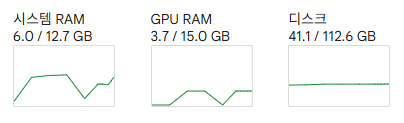

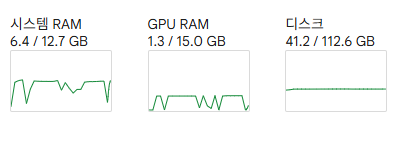